# Seurat clustering 96h

In [127]:
library(Seurat)
library(ggplot2)
library(SingleR)
library(dplyr)
library(celldex)
library(RColorBrewer)
library(SingleCellExperiment)
library(repr)



ERROR: Error in library(SingleR): there is no package called ‘SingleR’


In [128]:
Gastruloid_96h_afterQC <- readRDS("./files/Seurat_Obj_afterQC/Gastruloid_96h_afterQC.rds")

# Processing of the data

In [129]:
mGast.list <- list(Gastruloid_96h_afterQC)
mGast.list <- lapply(X = mGast.list, FUN = function(x) {
  x <- NormalizeData(x, verbose = FALSE)
  x <- FindVariableFeatures(x, verbose = FALSE)
  x <- ScaleData(x, verbose = FALSE)
  x <- RunPCA(x, verbose = FALSE)
  x <- RunUMAP(x, dims = 1:30, n.neighbors=10)
  x <- FindNeighbors(x, dims = 1:20)
  x <- FindClusters(x, resolution = 0.3)
  
})
Gastruloid_96h_afterQC <- mGast.list[[1]]

11:49:42 UMAP embedding parameters a = 0.9922 b = 1.112

11:49:42 Read 2767 rows and found 30 numeric columns

11:49:42 Using Annoy for neighbor search, n_neighbors = 10

11:49:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:49:43 Writing NN index file to temp file /scratch/local/RtmptGFIhD/file1fe657cb5a66f

11:49:43 Searching Annoy index using 1 thread, search_k = 1000

11:49:43 Annoy recall = 100%

11:49:44 Commencing smooth kNN distance calibration using 1 thread

11:49:45 Initializing from normalized Laplacian + noise

11:49:45 Commencing optimization for 500 epochs, with 38116 positive edges

11:49:47 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2767
Number of edges: 99134

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8755
Number of communities: 6
Elapsed time: 0 seconds


# Cell cycle scoring

In [131]:
# Cell cycle scoring and regression

# Reading cell cycle file 
cell.cycle <- read.table("../files/Macosko_cell_cycle_genes.txt", header = T, sep = '\t')
s.genes <- cell.cycle$S
s.genes <- paste(toupper(substr(s.genes, 1, 1)), substr(tolower(s.genes), 2, nchar(s.genes)), sep="")
g2m.genes <- cell.cycle$G2.M
g2m.genes <- paste(toupper(substr(g2m.genes, 1, 1)), substr(tolower(g2m.genes), 2, nchar(g2m.genes)), sep="")


In [132]:
# checking in they are present in our dataset
table(s.genes %in% rownames(Gastruloid_96h_afterQC))
table(g2m.genes %in% rownames(Gastruloid_96h_afterQC))


FALSE  TRUE 
   50   101 


FALSE  TRUE 
   27   124 

In [133]:
# keeping only those that are found (otherwise the regression is not working)
s.genes <- s.genes[s.genes %in% rownames(Gastruloid_96h_afterQC)]
g2m.genes <- g2m.genes[g2m.genes %in% rownames(Gastruloid_96h_afterQC)]

In [134]:
# cell cycle scoring
Gastruloid_96h_afterQC <- CellCycleScoring(Gastruloid_96h_afterQC, s.features = s.genes, g2m.features = g2m.genes, set.ident = T)

# Cell cycle regression 

In [136]:
# scaling the data with regression of cell cycle genes
Gastruloid_96h_afterQC <- ScaleData(Gastruloid_96h_afterQC, vars.to.regress = c("S.Score", "G2M.Score"), verbose = FALSE)
Gastruloid_96h_afterQC <- RunPCA(Gastruloid_96h_afterQC, verbose = FALSE)
Gastruloid_96h_afterQC <- RunUMAP(Gastruloid_96h_afterQC, dims = 1:30, n.neighbors=10)


11:51:05 UMAP embedding parameters a = 0.9922 b = 1.112

11:51:05 Read 2767 rows and found 30 numeric columns

11:51:05 Using Annoy for neighbor search, n_neighbors = 10

11:51:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:51:06 Writing NN index file to temp file /scratch/local/RtmptGFIhD/file1fe653300ff86

11:51:06 Searching Annoy index using 1 thread, search_k = 1000

11:51:06 Annoy recall = 100%

11:51:06 Commencing smooth kNN distance calibration using 1 thread

11:51:07 Initializing from normalized Laplacian + noise

11:51:07 Commencing optimization for 500 epochs, with 38740 positive edges

11:51:10 Optimization finished



# Violin plot by Seurat cluster

Check that there is no cluster formed by cells having low number of nCount and/or nFeature (low quality)

In [138]:
Idents(object = Gastruloid_96h_afterQC) <- "seurat_clusters"

In [140]:
library(ggplot2)
# theme
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")
theme_niwot <- function(){
  theme_bw() +
    theme(text = element_text(family = "Helvetica Light"),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          axis.line.x = element_line(color="black"),
          axis.line.y = element_line(color="black"),
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.y = element_blank(),
          plot.margin = unit(c(1, 1, 1, 1), units = , "cm"),
          plot.title = element_text(size = 18, vjust = 1, hjust = 0),
          legend.text = element_text(size = 12),
          legend.title = element_blank(),
          legend.position = "right",
          legend.key = element_blank(),
          legend.background = element_rect(color = "black",
                                           fill = "transparent",
                                           size = 2, linetype = "blank"))}

In [141]:
metadata <- Gastruloid_96h_afterQC@meta.data
colnames(metadata)
dim(metadata)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "Sample.barcode" 
 [5] "Morphotype"      "percent.mt"      "RNA_snn_res.0.3" "seurat_clusters"
 [9] "S.Score"         "G2M.Score"       "Phase"           "old.ident"

[1] 2767   12

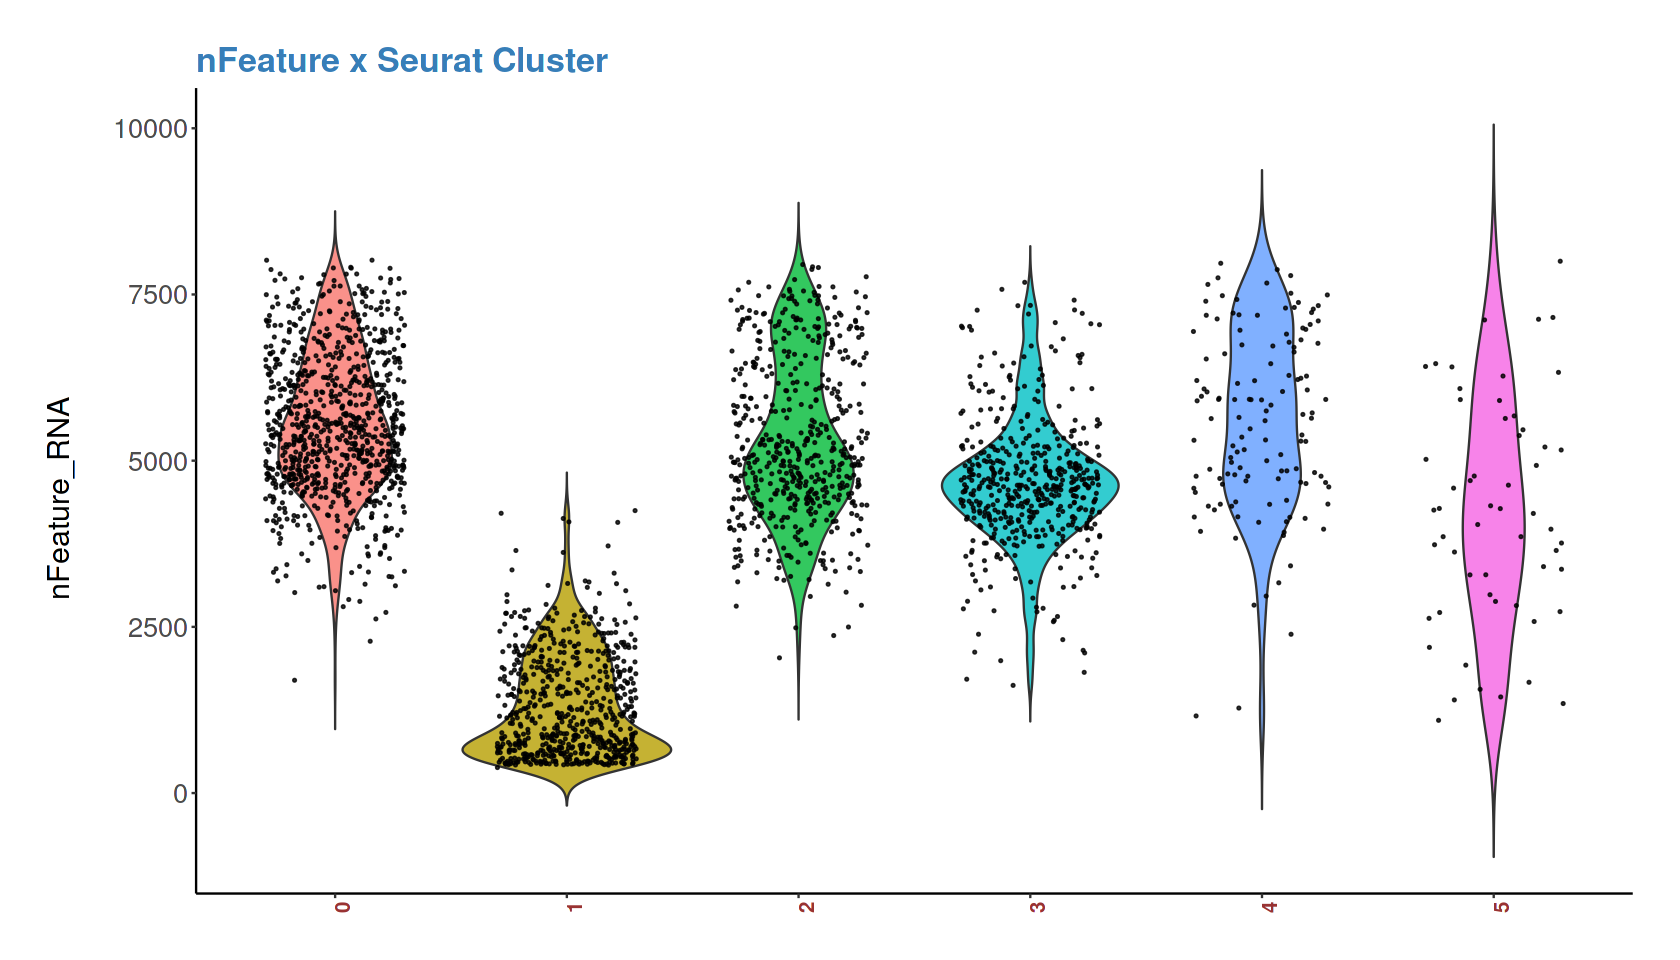

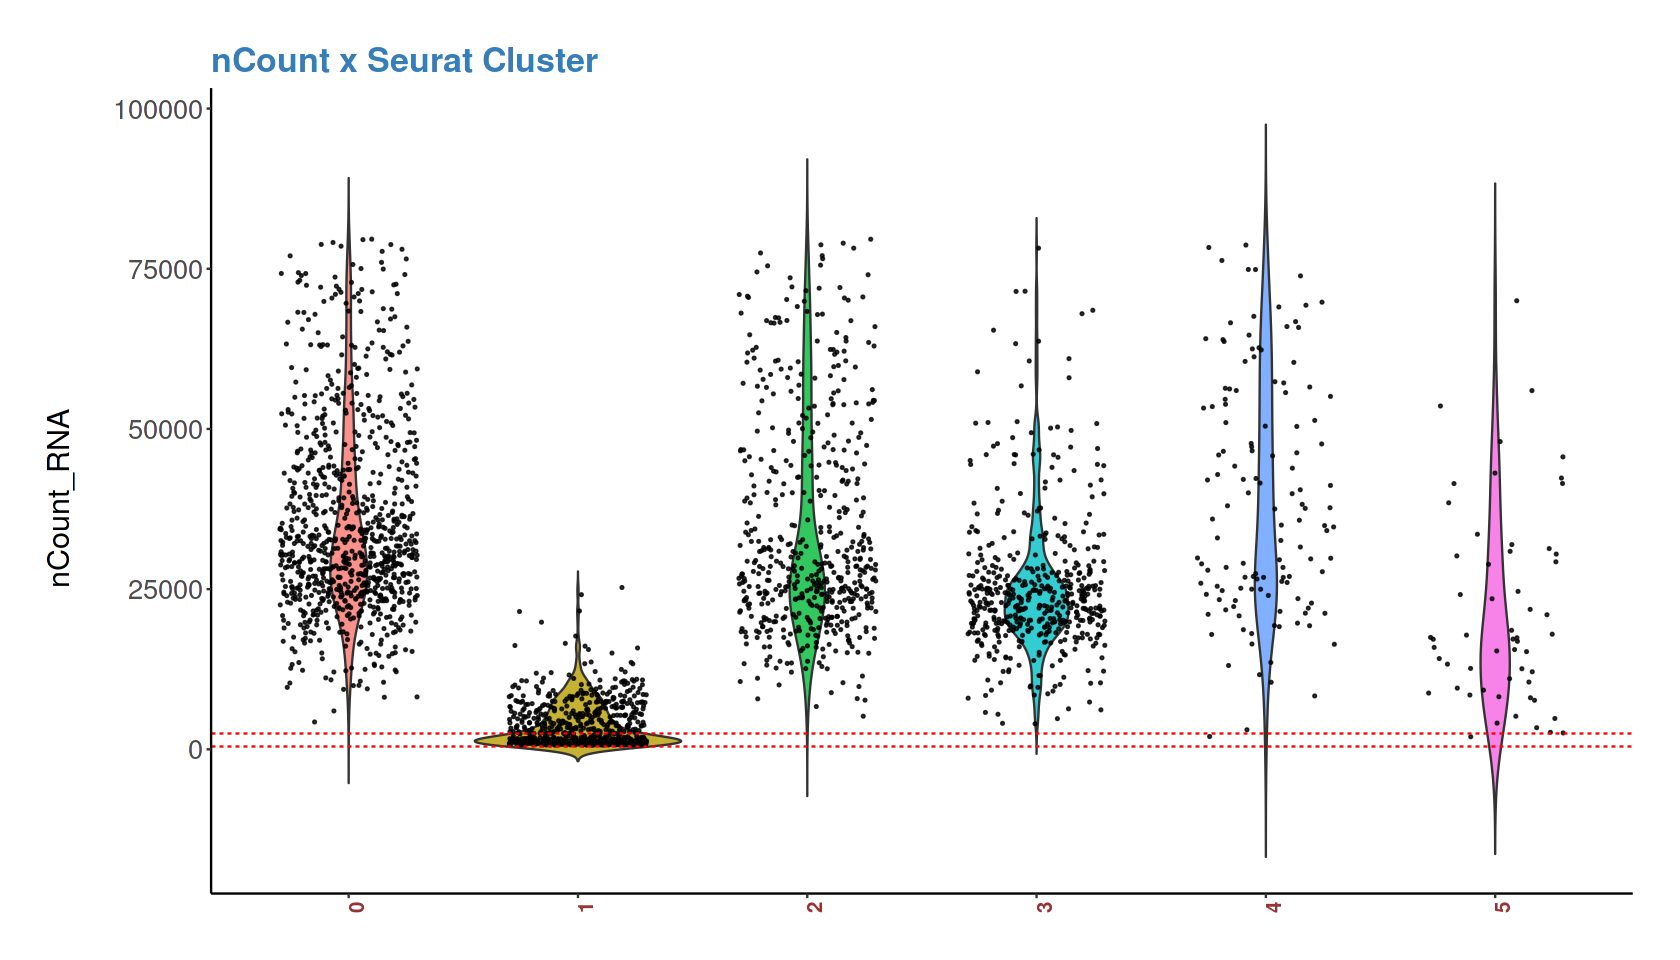

In [143]:
options(repr.plot.width=14, repr.plot.height=8)
ggplot(data = metadata, 
       aes(x = seurat_clusters, y = (nFeature_RNA), fill= seurat_clusters)) +
  # The half violins
  geom_violin(position = position_nudge(x = 0, y = 0), alpha = 0.8, trim=FALSE) +
  # The points
  geom_point(aes(y = (nFeature_RNA)),
             position = position_jitter(width = 0.3), size = 0.4, alpha = 0.8) +
  # The boxplots
  # geom_boxplot(width = 0.2, outlier.shape = NA, alpha = 0.6) +
  # \n adds a new line which creates some space between the axis and axis title
  labs(y = "nFeature_RNA  \n", x = NULL) +
  # Removing legends
  guides(fill = FALSE, color = FALSE) +
  # Setting the limits of the y axis
  #scale_y_continuous(limits = c(25, 40)) +
  # Picking nicer colours
  #scale_fill_manual(values = colours) +
  #scale_x_discrete(labels=as.character(labels_beforeQC)) +
  theme_niwot() +
  # geom_hline(yintercept=1000, linetype="dashed", color = "red") +
  ggtitle("nFeature x Seurat Cluster") +
  theme(axis.text.x = element_text(face="bold", color="#993333", 
                           size=12, angle=90),
       plot.title = element_text(color="#377eb8", size=20, face="bold"))

ggplot(data = metadata, 
       aes(x = seurat_clusters, y = (nCount_RNA), fill= seurat_clusters)) +
  # The half violins
  geom_violin(position = position_nudge(x = 0, y = 0), alpha = 0.8, trim=FALSE) +
  # The points
  geom_point(aes(y = (nCount_RNA)),
             position = position_jitter(width = 0.3), size = 0.4, alpha = 0.8) +
  # The boxplots
  # geom_boxplot(width = 0.2, outlier.shape = NA, alpha = 0.6) +
  # \n adds a new line which creates some space between the axis and axis title
  labs(y = "nCount_RNA  \n", x = NULL) +
  # Removing legends
  guides(fill = FALSE, color = FALSE) +
  # Setting the limits of the y axis
  #scale_y_continuous(limits = c(25, 40)) +
  # Picking nicer colours
  #scale_fill_manual(values = colours) +
  #scale_x_discrete(labels=as.character(labels_beforeQC)) +
  theme_niwot() +
  geom_hline(yintercept=2500, linetype="dashed", color = "red") +
  geom_hline(yintercept=500, linetype="dashed", color = "red") +
  ggtitle("nCount x Seurat Cluster") +
  theme(axis.text.x = element_text(face="bold", color="#993333", 
                           size=12, angle=90),
       plot.title = element_text(color="#377eb8", size=20, face="bold"))

Remove cluster 1

# Removing cluster with low nCount

In [144]:
# To subset and remove single cluster and keep the remaining clusters for new analysis
Gastruloid_96h_afterQC <- subset(Gastruloid_96h_afterQC, idents = 1, invert = TRUE)


## Reclustering the data after removing cluster

In [149]:
x <- NormalizeData(Gastruloid_96h_afterQC, verbose = FALSE)
x <- FindVariableFeatures(x, verbose = FALSE)
x <- ScaleData(x, verbose = FALSE)
x <- RunPCA(x, verbose = FALSE)
x <- RunUMAP(x, dims = 1:30, n.neighbors=10)
x <- FindNeighbors(x, dims = 1:20)
x <- FindClusters(x, resolution = 0.3)

11:55:33 UMAP embedding parameters a = 0.9922 b = 1.112

11:55:33 Read 2116 rows and found 30 numeric columns

11:55:33 Using Annoy for neighbor search, n_neighbors = 10

11:55:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:55:33 Writing NN index file to temp file /scratch/local/RtmptGFIhD/file1fe65137ddba9

11:55:33 Searching Annoy index using 1 thread, search_k = 1000

11:55:34 Annoy recall = 100%

11:55:34 Commencing smooth kNN distance calibration using 1 thread

11:55:35 Initializing from normalized Laplacian + noise

11:55:35 Commencing optimization for 500 epochs, with 27754 positive edges

11:55:37 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2116
Number of edges: 71443

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8373
Number of communities: 5
Elapsed time: 0 seconds


In [151]:
Gastruloid_96h_afterQC <- x

# Saving the data

In [158]:
metadata_96h_afterQC <- Gastruloid_96h_afterQC@meta.data

In [159]:
# Save the files
saveRDS(Gastruloid_96h_afterQC, file = "./files/Seurat_Obj_afterQC/SeuratClustering_individual_timepoints/Gastruloid_96h_afterQC.rds")
saveRDS(metadata_96h_afterQC, file = "./files/Seurat_Obj_afterQC/SeuratClustering_individual_timepoints/metadata_96h_afterQC.rds")